In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import p2pspatial
import pulse2percept.utils as p2pu

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-04-24 17:23:39,484 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        best_cost = 0
        r2_scores = {}
        for col in y_pred.drop(columns=['electrode', 'image']).columns:
#             yt = np.array(y.loc[:, col], dtype=float)
#             yp = np.array(y_pred.loc[:, col], dtype=float)
            yt = y.loc[:, col]
            yp = y_pred.loc[:, col]

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                # ss_tot = np.sum((yt - np.mean(yt)) ** 2)
                ss_tot = spst.circvar(yt, low=-np.pi / 2, high=np.pi / 2)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'adjust_bias': specifics['adjust_bias'],
            'best_cost': best_cost,
            'n_samples': len(yt),
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
#         row.update(best_params)
        row.update(r2_scores)
        data.append(row)
    return pd.DataFrame(data)

In [3]:
results_dir = '../../results/shape6fit/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 14 files


In [4]:
subjects = ['12-005', '51-009', '52-001', 'TB']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [5]:
data = load_data(pickle_files, verbose=False)
data

,adjust_bias,best_cost,exetime,filename,filepath,model,n_samples,r2_area,r2_compactness,r2_eccentricity,r2_orientation,subject
0,False,5.983599,316.994262,12-005_C__shape6fit-swarm_2018-04-23_22-48-35....,../../results/shape6fit,C,9,0.308381,-0.748647,-1.708551,0.165218,12-005
1,False,6.080598,453.016855,12-005_C__shape6fit-swarm_2018-04-23_22-53-54....,../../results/shape6fit,C,9,0.124028,-0.738554,-1.627495,0.161423,12-005
2,False,6.000745,1036.543010,12-005_C__shape6fit-swarm_2018-04-23_23-01-32....,../../results/shape6fit,C,9,0.292452,-0.761742,-1.693535,0.162080,12-005
3,False,1225.456753,29658.351452,51-009_C2__shape6fit-swarm_2018-04-23_23-12-49...,../../results/shape6fit,C2,14,0.305054,-5.079970,-1217.017012,0.335175,51-009
4,False,14.711561,816.664213,51-009_C__shape6fit-swarm_2018-04-23_22-49-40....,../../results/shape6fit,C,14,-2.122771,-7.382938,-1.217448,0.011596,51-009
5,False,14.805662,534.776440,51-009_C__shape6fit-swarm_2018-04-23_23-03-22....,../../results/shape6fit,C,14,-2.120863,-7.460649,-1.236233,0.012082,51-009
6,False,14.807602,551.485468,51-009_C__shape6fit-swarm_2018-04-23_23-12-22....,../../results/shape6fit,C,14,-2.132109,-7.449224,-1.238346,0.012077,51-009
7,False,71.139317,5588.007708,51-009_C__shape6fit-swarm_2018-04-24_09-54-50....,../../results/shape6fit,C,14,-10.263931,-0.909953,-56.202204,0.236771,51-009
8,False,3.747208,1566.069510,52-001_C__shape6fit-swarm_2018-04-23_18-05-41....,../../results/shape6fit,C,15,-0.254632,-0.321237,0.188431,0.640230,52-001
9,False,4.003913,510.538878,52-001_C__shape6fit-swarm_2018-04-23_18-31-53....,../../results/shape6fit,C,15,-0.373846,-0.260637,-0.030056,0.660626,52-001


In [6]:
data.n_samples.unique()

array([ 9, 14, 15,  8])

# All runs

In [7]:
# Group by these:
groupcols = ['subject', 'model', 'adjust_bias']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
r2cols = ['r2_area', 'r2_orientation', 'r2_eccentricity', 'r2_compactness']

In [8]:
data.groupby(groupcols)['exetime', 'best_cost'].agg(['mean', 'std', 'count'])

exetime                       best_cost  \
                                   mean          std count         mean   
subject model adjust_bias                                                 
12-005  C     False          602.184709   382.264159     3     6.021647   
51-009  C     False         1872.733457  2480.213044     4    28.866036   
        C2    False        29658.351452          NaN     1  1225.456753   
52-001  C     False         1508.393855   970.303611     3     3.666853   
TB      C     False         2035.148147  1678.252190     3     4.917284   

                                            
                                 std count  
subject model adjust_bias                   
12-005  C     False         0.051768     3  
51-009  C     False        28.182223     4  
        C2    False              NaN     1  
52-001  C     False         0.383602     3  
TB      C     False         0.326538     3

# The best runs in their respective category

In [9]:
# 51-009
# Best err: 7.80698395097 Best params: {
#     'implant_x': -799.1442217201959, 
#     'loc_od_y': 0.7546936471295187, 
#     'rho': 50.0, 
#     'loc_od_x': 15.654335316168801, 
#     'implant_rot': -1.0921220639722116, 
#     'axlambda': 1103.7970402031128, 
#     'implant_y': 92.753210211560955}

In [10]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols)['best_cost'].transform(np.min) == data['best_cost']
data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols).min()

Best scores:


best_cost   r2_area  r2_compactness  \
subject model adjust_bias                                          
12-005  C     False           5.983599  0.308381       -0.748647   
51-009  C     False          14.711561 -2.122771       -7.382938   
        C2    False        1225.456753  0.305054       -5.079970   
52-001  C     False           3.249439  0.090753       -0.242765   
TB      C     False           4.582180 -0.992044       -0.225798   

                           r2_eccentricity  r2_orientation  
subject model adjust_bias                                   
12-005  C     False              -1.708551        0.165218  
51-009  C     False              -1.217448        0.011596  
        C2    False           -1217.017012        0.335175  
52-001  C     False               0.281033        0.621540  
TB      C     False               0.018713        0.616949

# Runs that give sufficiently good results

Predicts all four parameters:

In [11]:
best = data.loc[best_idx, :]
best4_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best4_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

""


Predicts at least 3 out of 4:

In [12]:
best3_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0)
best3_idx |= (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best3_idx |= (best['r2_eccentricity'] > 0) & (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best3_idx |= (best['r2_area'] > 0) & (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best3_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

,,,best_cost,filename,r2_area,r2_compactness,r2_eccentricity,r2_orientation
subject,model,adjust_bias,,,,,,
52-001,C,False,3.249439,52-001_C__shape6fit-swarm_2018-04-23_18-40-28....,0.090753,-0.242765,0.281033,0.62154


Predicts at least 2 out of 4:

In [13]:
best2_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0)
best2_idx |= (best['r2_area'] > 0) & (best['r2_compactness'] > 0)
best2_idx |= (best['r2_area'] > 0) & (best['r2_eccentricity'] > 0)
best2_idx |= (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best2_idx |= (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0)
best2_idx |= (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best2_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

,,,best_cost,filename,r2_area,r2_compactness,r2_eccentricity,r2_orientation
subject,model,adjust_bias,,,,,,
12-005,C,False,5.983599,12-005_C__shape6fit-swarm_2018-04-23_22-48-35....,0.308381,-0.748647,-1.708551,0.165218
51-009,C2,False,1225.456753,51-009_C2__shape6fit-swarm_2018-04-23_23-12-49...,0.305054,-5.079970,-1217.017012,0.335175
52-001,C,False,3.249439,52-001_C__shape6fit-swarm_2018-04-23_18-40-28....,0.090753,-0.242765,0.281033,0.621540
TB,C,False,4.582180,TB_C__shape6fit-swarm_2018-04-24_08-32-19.pickle,-0.992044,-0.225798,0.018713,0.616949


In [14]:
best1_idx = (best['r2_area'] > 0)
best1_idx |= (best['r2_compactness'] > 0)
best1_idx |= (best['r2_eccentricity'] > 0)
best1_idx |= (best['r2_orientation'] > -20)
best.loc[best1_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

best_cost  \
subject model adjust_bias                
12-005  C     False           5.983599   
51-009  C     False          14.711561   
        C2    False        1225.456753   
52-001  C     False           3.249439   
TB      C     False           4.582180   

                                                                    filename  \
subject model adjust_bias                                                      
12-005  C     False        12-005_C__shape6fit-swarm_2018-04-23_22-48-35....   
51-009  C     False        51-009_C__shape6fit-swarm_2018-04-23_22-49-40....   
        C2    False        51-009_C2__shape6fit-swarm_2018-04-23_23-12-49...   
52-001  C     False        52-001_C__shape6fit-swarm_2018-04-23_18-40-28....   
TB      C     False         TB_C__shape6fit-swarm_2018-04-24_08-32-19.pickle   

                            r2_area  r2_compactness  r2_eccentricity  \
subject model adjust_bias                                              
12-005  C     False        0.308381       -0.748647        -1.708551   
51-009  C     False       -2.122771       -7.382938        -1.217448   
        C2    False        0.305054       -5.079970     -1217.017012   
52-001  C     False        0.090753       -0.242765         0.281033   
TB      C     False       -0.992044       -0.225798         0.018713   

                           r2_orientation  
subject model adjust_bias                  
12-005  C     False              0.165218  
51-009  C     False              0.011596  
        C2    False              0.335175  
52-001  C     False              0.621540  
TB      C     False              0.616949

In [15]:
plot_files = best.loc[best1_idx, :].reset_index()

In [16]:
plot_files = best.reset_index()[best.reset_index()['subject'] == '51-009']

In [17]:
y, _, best_params, _ = pickle.load(open(os.path.join(*plot_files.loc[plot_files.index[0], ['filepath', 'filename']]), 'rb'))
if isinstance(y, list):
    y = pd.concat(y)
columns = y.drop(columns=['electrode', 'image']).columns
columns

Index(['area', 'compactness', 'eccentricity', 'orientation'], dtype='object')

In [18]:
best_params

{'axlambda': 1103.7970402031128,
 'implant_rot': -1.0921220639722116,
 'implant_x': -799.1442217201959,
 'implant_y': 92.753210211560955,
 'loc_od_x': 15.654335316168801,
 'loc_od_y': 0.7546936471295187,
 'rho': 50.0}

# Plot best ones

['A02' 'C01' 'C05' 'C06' 'D03' 'E01' 'E05' 'E07' 'F04' 'F06']
Empty DataFrame
Columns: [area, compactness, eccentricity, electrode, image, orientation]
Index: [] Empty DataFrame
Columns: [area, compactness, eccentricity, electrode, image, orientation]
Index: []


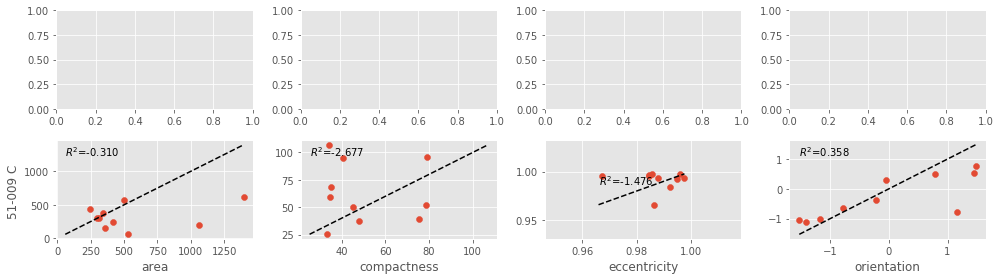

In [33]:
fig, axes = plt.subplots(ncols=len(columns), nrows=np.maximum(2, len(plot_files)), 
                         figsize=(14, 2 * np.maximum(2, len(plot_files))))
for (_, row), axrow in zip(plot_files.iterrows(), axes):
    if row['model'] != 'C':
        continue
    y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))
    if isinstance(y, list):
        y = pd.concat(y)
        y_pred = pd.concat(y_pred)
    idx = y['electrode'] == 'B04'
    idx = np.logical_or(idx, y['electrode'] == 'B03')
#     idx = np.logical_or(y['electrode'] == 'C01', y['electrode'] == 'D03')
    idx = np.logical_or(idx, y['electrode'] == 'C08')
    idx = np.logical_or(idx, y['electrode'] == 'E09')
    y = y[np.logical_not(idx)]
    y_pred = y_pred[np.logical_not(idx)]
    print(y.electrode.unique())
    row['r2_area'] = sklm.r2_score(y['area'], np.nan_to_num(y_pred['area']))
    row['r2_compactness'] = sklm.r2_score(y['compactness'], np.nan_to_num(y_pred['compactness']))
    row['r2_eccentricity'] = sklm.r2_score(y['eccentricity'], np.nan_to_num(y_pred['eccentricity']))
    err = np.abs(y['orientation'] - np.nan_to_num(y_pred['orientation']))
    err = np.where(err > np.pi / 2, np.pi - err, err)
    # Use circular variance in `ss_tot`, which divides by len(yt).
    # Therefore, we also need to divide `ss_res` by len(yt), which
    # is the same as taking the mean instead of the sum.
    ss_res = np.mean(err ** 2)
    # ss_tot = np.sum((yt - np.mean(yt)) ** 2)
    ss_tot = spst.circvar(y['orientation'], low=-np.pi / 2, high=np.pi / 2)
    row['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
                
    cond = y_pred['area'] > 1500
    print(y[cond], y_pred[cond])
    for col, ax in zip(columns, axrow):
        ax.scatter(y[col], y_pred[col])
        minval = np.minimum(y[col].min(), y_pred[col].min())
        maxval = np.maximum(y[col].max(), y_pred[col].max())
        ax.plot([minval, maxval], [minval, maxval], 'k--')
        ax.set_xlabel(col)
        ax.text(minval, maxval, "$R^2$=%.3f" % float(row['r2_' + col]), va='top')
    axrow[0].set_ylabel('%s %s %s' % (row['subject'], row['model'],
                                      "adjust" if row['adjust_bias'] else ""))
#     break
fig.tight_layout()

In [20]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [21]:
y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))

In [22]:
for col in columns:
    df = pd.DataFrame({'y': y[col], 'y_hat': y_pred[col]})
    model = ols('y ~ y_hat', data=df).fit()
    anovaResults = anova_lm(model)
    print('')
    print(col)
    print(anovaResults)


area
            df        sum_sq        mean_sq         F    PR(>F)
y_hat      1.0  6.308132e+04   63081.323887  0.596207  0.454967
Residual  12.0  1.269652e+06  105804.342057       NaN       NaN

compactness
            df       sum_sq     mean_sq        F    PR(>F)
y_hat      1.0    35.481149   35.481149  0.11314  0.742406
Residual  12.0  3763.234263  313.602855      NaN       NaN

eccentricity
            df        sum_sq       mean_sq         F    PR(>F)
y_hat      1.0  5.513659e-07  5.513659e-07  0.008325  0.928808
Residual  12.0  7.948088e-04  6.623406e-05       NaN       NaN

orientation
            df     sum_sq   mean_sq         F    PR(>F)
y_hat      1.0   4.039652  4.039652  3.712222  0.078026
Residual  12.0  13.058439  1.088203       NaN       NaN


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
